In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

In [3]:
# Simplified Image Parameters
img_size = 256  # Reduced image size for faster processing
batch_size = 16  # Smaller batch size for less memory usage

# Simplified Image Data Generators with lighter augmentation
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,  # Reduced rotation
    width_shift_range=0.1,  # Reduced shifts
    height_shift_range=0.1,
    zoom_range=0.1,  # Lighter zoom
    horizontal_flip=True,  # Retain flipping
)

# Train Generator with Augmentation
train_generator = data_gen.flow_from_directory(
    "data/Grape/Train",
    target_size=(img_size, img_size),  # Smaller image size for faster training
    batch_size=batch_size,
    class_mode='categorical'
)

# Validation Generator (No Augmentation but Still Rescaled)
validation_generator = data_gen.flow_from_directory(
    "data/Grape/Val",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# Validation Generator (No Augmentation but Still Rescaled)
test_generator = data_gen.flow_from_directory(
    "data/Grape/Test",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 7218 images belonging to 4 classes.
Found 1623 images belonging to 4 classes.
Found 182 images belonging to 4 classes.


In [4]:
class_names = train_generator.class_indices
class_names

{'Black Rot': 0, 'Esca (Black Measles)': 1, 'Healthy': 2, 'Leaf Blight': 3}

In [5]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Enhanced Model Definition
model = models.Sequential()

# First Convolutional Block
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)))
model.add(layers.BatchNormalization())  # Normalizing activations to improve training
model.add(layers.MaxPooling2D(2, 2))

# Second Convolutional Block
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())  # Batch normalization to stabilize learning
model.add(layers.MaxPooling2D(2, 2))

# Third Convolutional Block
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2, 2))

# Fourth Convolutional Block (optional for deeper learning)
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(2, 2))

# Flattening the 3D feature maps to 1D vectors
model.add(layers.Flatten())

# Fully Connected Dense Layer with Dropout for Regularization
model.add(layers.Dense(128, activation='relu'))
#model.add(layers.Dropout(0.5))  # Dropout to prevent overfitting

# Output Layer: Number of units = number of classes, activation function = softmax for multi-class classification
model.add(layers.Dense(train_generator.num_classes, activation='softmax'))

# Displaying the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125, 64)     256       
 hNormalization)                                                 
                                                        

In [6]:
# Compile the model with Adam optimizer and categorical crossentropy loss
# - Adam: An adaptive learning rate optimization algorithm
# - Categorical Crossentropy: Suitable for multi-class classification problems..
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks for early stopping and saving the best model
#callbacks = [
    #EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),  # Stop early if validation loss doesn't improve
    #ModelCheckpoint('best_model.keras', save_best_only=True)  # Save the best model with .keras extension
#]

# Training the model
history = model.fit(
    train_generator,  # Training data
    steps_per_epoch=train_generator.samples // batch_size,  # Number of batches of training data to run per epoch
    epochs=5,  # Adjust based on data size and performance
    validation_data=validation_generator,  # Validation data
    validation_steps=validation_generator.samples // batch_size,  # Number of validation steps
    callbacks=None  # Include the callbacks
)

Epoch 1/5
451/451 [==============================] - 291s 643ms/step - loss: 0.3282 - accuracy: 0.8764 - val_loss: 3.7596 - val_accuracy: 0.4746
Epoch 2/5
451/451 [==============================] - 410s 909ms/step - loss: 0.1674 - accuracy: 0.9397 - val_loss: 0.1839 - val_accuracy: 0.9344
Epoch 3/5
451/451 [==============================] - 316s 701ms/step - loss: 0.1199 - accuracy: 0.9561 - val_loss: 0.1400 - val_accuracy: 0.9511
Epoch 4/5
451/451 [==============================] - 320s 708ms/step - loss: 0.0839 - accuracy: 0.9701 - val_loss: 0.0635 - val_accuracy: 0.9728
Epoch 5/5
451/451 [==============================] - 312s 690ms/step - loss: 0.0718 - accuracy: 0.9729 - val_loss: 0.0561 - val_accuracy: 0.9808


In [8]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

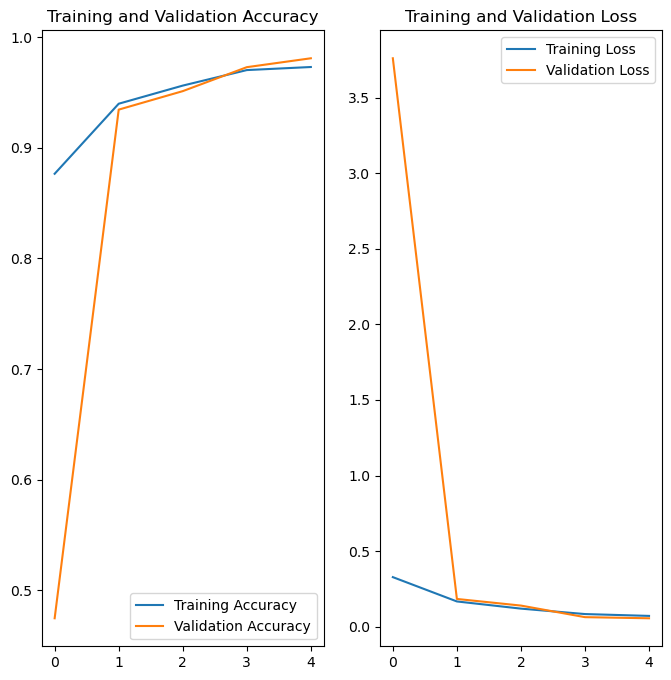

In [9]:
epochs=5
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [10]:
model.evaluate(test_generator)

12/12 [==============================] - 4s 357ms/step - loss: 0.0637 - accuracy: 0.9835


[0.06371193379163742, 0.9835164546966553]

In [11]:
import json
import random
from zipfile import ZipFile
from PIL import Image

In [12]:
# Create a mapping from class indices to class names
class_indice = {v: k for k, v in train_generator.class_indices.items()}

class_indice


# saving the class names as json file
json.dump(class_indice, open('class_indices1.json', 'w'))

first image to Predict
Actual Label: Leaf Blight
1/1 [==============================] - 0s 363ms/step
Predicted Label: Leaf Blight


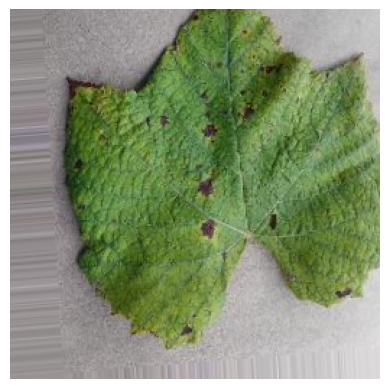

In [13]:
# Get one batch of images and labels
batch = next(test_generator)  # Get the batch without unpacking
image_batch, label_batch = batch  # Now unpack it

# Access the first image and its corresponding label
first_image = image_batch[0]  # This is already a numpy array
first_label = label_batch[0]   # This is also already a numpy array

print('first image to Predict')

# Display the first image
plt.imshow(first_image)
print("Actual Label: {}".format(class_indice[np.argmax(first_label)]))
plt.axis("off")
batch_prediction = model.predict(image_batch)
print('Predicted Label:', class_indice[np.argmax(batch_prediction[0])])
plt.show()


In [14]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #Create batch

    prediction = model.predict(img_array)

    Predicted_class = class_names[np.argmax(prediction[0])]
    Confidence = round(100*(np.max(prediction[0])), 2)
    return Predicted_class, Confidence

1/1 [==============================] - 0s 42ms/step


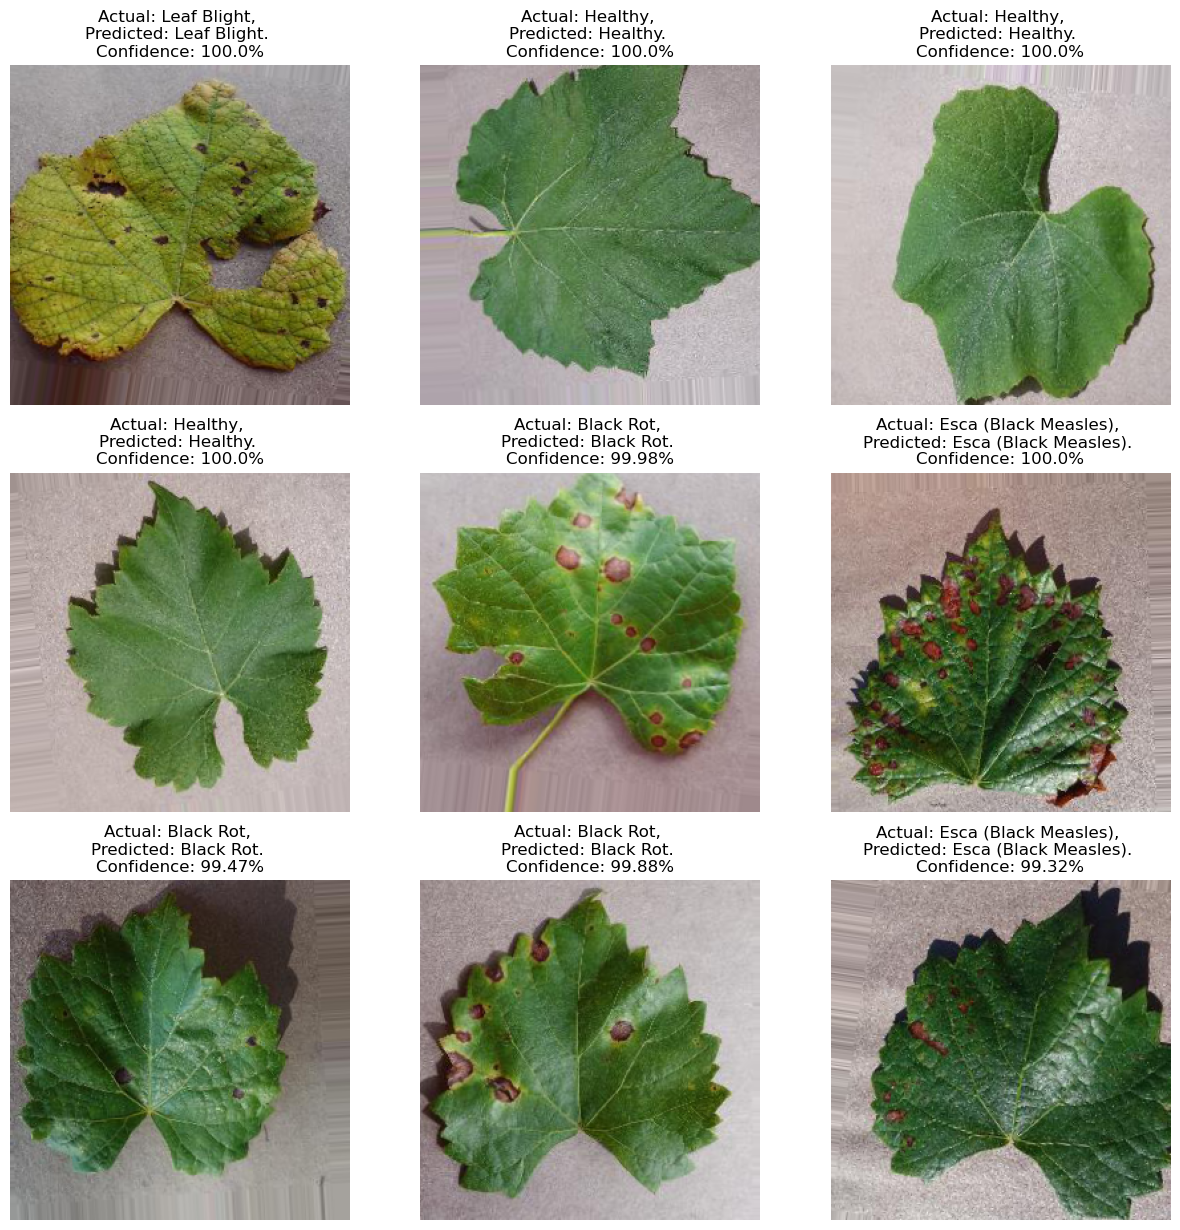

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Function to predict the class of a single image
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create batch dimension
    prediction = model.predict(img_array)
    predicted_class = class_indice[np.argmax(prediction[0])]
    confidence = round(100 * np.max(prediction[0]), 2)
    return predicted_class, confidence

# Function to visualize predictions for multiple images
def visualize_predictions(model, generator, class_indice, num_images=9):
    # Get one batch of images and labels
    batch = next(generator)
    image_batch, label_batch = batch

    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        ax = plt.subplot(3, 3, i + 1)
        
        # Display the image
        plt.imshow(image_batch[i])  # Already a numpy array

        # Get the actual label
        actual_label = class_indice[np.argmax(label_batch[i])]
        
        # Predict using the provided function
        predicted_class, confidence = predict(model, image_batch[i])

        # Set the title with actual and predicted labels
        plt.title(f"Actual: {actual_label}, \nPredicted: {predicted_class}. \nConfidence: {confidence}%")
        plt.axis("off")

    plt.show()

# Example usage:
visualize_predictions(model, test_generator, class_indice, num_images=9)


In [16]:
# Function to Load and Preprocess the Image using Pillow
def load_and_preprocess_image(image_path, target_size=(256, 256)):
    # Load the image using Pillow
    img = Image.open(image_path)
    # Resize the image to match the input size of the model
    img = img.resize(target_size)
    # Convert the image to a numpy array
    img_array = np.array(img)
    # Add a batch dimension (required for model.predict)
    img_array = np.expand_dims(img_array, axis=0)
    # Normalize the image values to the range [0, 1]
    img_array = img_array.astype('float32') / 255.
    return img_array

# Function to Predict the Class of an Image
def predict_image_class(model, image_path, class_indices):
    # Preprocess the input image
    preprocessed_img = load_and_preprocess_image(image_path)
    # Make predictions on the preprocessed image
    predictions = model.predict(preprocessed_img)
    # Get the index of the class with the highest prediction score
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    # Convert the class index back to the class name
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name

In [18]:
# Example Usage: Predict the class of an image
image_path = r"C:\Users\joshu\OneDrive\Documents\Fall 2024\Project 1\Grape_Image-Classification\data\Grape\Test\Esca (Black Measles)\1a450cce-95a7-4b1e-a641-95b4d50a1acc___FAM_B.Msls 1747.JPG"

# Predict the class of the image
predicted_class_name = predict_image_class(model, image_path, class_indice)

# Output the predicted class name
print("Predicted Class Name:", predicted_class_name)

1/1 [==============================] - 0s 24ms/step
Predicted Class Name: Esca (Black Measles)


In [19]:
# Save the model locally
model.save('prediction_model_V3.h5')
model.save('prediction_model_V3.keras')

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data/Grape_dataset",
    shuffle=True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= 16
)

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    test_size = int(test_split*ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
import numpy as np
import tensorflow as tf

# Lists to hold predictions and true labels
true_labels = []
predictions = []

# Iterate through the validation dataset
for image_batch, label_batch in val_ds:
    # Make predictions
    preds = model.predict(image_batch)
    preds_labels = np.argmax(preds, axis=-1)
    
    # Extend lists
    true_labels.extend(label_batch.numpy())
    predictions.extend(preds_labels)

# Convert lists to numpy arrays for compatibility with scikit-learn
true_labels = np.array(true_labels)
predictions = np.array(predictions)


In [25]:
import numpy as np

true_labels = []
predictions = []

# Use a generator to iterate through the validation dataset
for image_batch, label_batch in validation_generator:
    preds = model.predict(image_batch)
    preds_labels = np.argmax(preds, axis=-1)

    true_labels.append(label_batch)
    predictions.append(preds_labels)

# Concatenate the results once at the end
true_labels = np.concatenate(true_labels)
predictions = np.concatenate(predictions)

1/1 [==============================] - 0s 199ms/step


KeyboardInterrupt: 

In [22]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels, predictions, target_names=class_names, output_dict=True)

# Convert the report to a DataFrame for better readability
import pandas as pd

report_df = pd.DataFrame(report).transpose()
print(report_df)

ValueError: Found input variables with inconsistent numbers of samples: [5610, 44716]

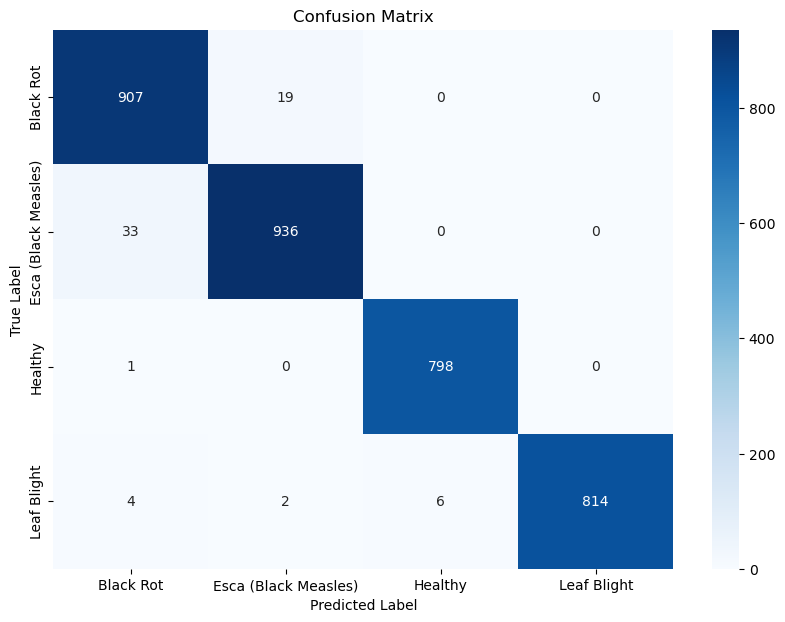

In [ ]:
import seaborn as  sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()